In [33]:
#Import the libraries we need
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [142]:
#Show library versions
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"MetaTrader 5 version: {mt5.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Pandas version: 1.5.3
Numpy version: 1.24.4
MetaTrader 5 version: 5.0.45
Matplotlib version: 3.7.1
Seaborn version: 0.13.0
Scikit-learn version: 1.2.2


In [34]:
#Initialize the terminal
mt5.initialize()

True

In [35]:
#Define how far ahead into the future we should forecast
look_ahead = 20

In [36]:
#Fetch historical market data 
usa_10y_bond = pd.DataFrame(mt5.copy_rates_from_pos("UST10Y_U4",mt5.TIMEFRAME_M1,0,100000))
jpn_10y_bond = pd.DataFrame(mt5.copy_rates_from_pos("JGB10Y_U4",mt5.TIMEFRAME_M1,0,100000))
usd_jpy      = pd.DataFrame(mt5.copy_rates_from_pos("USDJPY",mt5.TIMEFRAME_M1,0,100000))

In [37]:
#Convert the time from seconds
usa_10y_bond["time"] = pd.to_datetime(usa_10y_bond["time"],unit="s")
jpn_10y_bond["time"] = pd.to_datetime(jpn_10y_bond["time"],unit="s")
usd_jpy["time"] = pd.to_datetime(usd_jpy["time"],unit="s")

In [38]:
#Prepare to merge the data
usa_10y_bond.set_index("time",inplace=True)
jpn_10y_bond.set_index("time",inplace=True)
usd_jpy.set_index("time",inplace=True)

In [39]:
#Merge the data
merged_data = usa_10y_bond.merge(jpn_10y_bond,how="inner",left_index=True,right_index=True,suffixes=(" usa"," japan"))
merged_data = merged_data.merge(usd_jpy,left_index=True,right_index=True)

In [40]:
#Let's create a copy of the dataframe that we will use for plotting purposes
data_visualization = merged_data

In [41]:
#Reset the index
data_visualization.reset_index(inplace=True)

In [42]:
#Let's scale the data so all the first values in the column are one
for i in np.arange(1,data_visualization.shape[1]):
    data_visualization.iloc[:,i] = data_visualization.iloc[:,i] / data_visualization.iloc[0,i]

C:\Users\Westwood\AppData\Local\Temp\ipykernel_15988\1003546241.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_visualization.iloc[:,i] = data_visualization.iloc[:,i] / data_visualization.iloc[0,i]


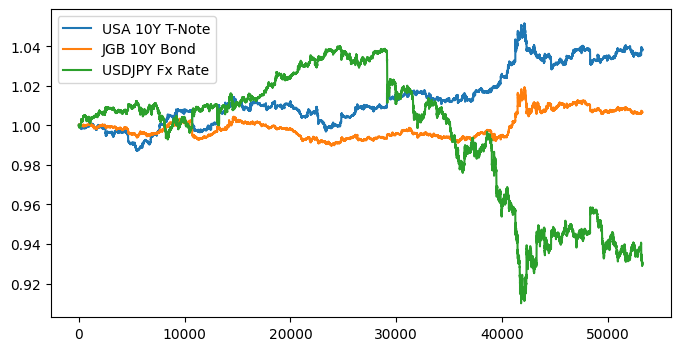

In [44]:
#Let's create a plot
plt.figure(figsize=(8, 4))
plt.plot(data_visualization.loc[:,"open usa"])
plt.plot(data_visualization.loc[:,"open japan"])
plt.plot(data_visualization.loc[:,"open"])
plt.legend(["USA 10Y T-Note","JGB 10Y Bond","USDJPY Fx Rate"])

In [43]:
#Let's create a new feature to show the spread between the securities
data_visualization["spread"] = data_visualization["open usa"] - data_visualization["open japan"]

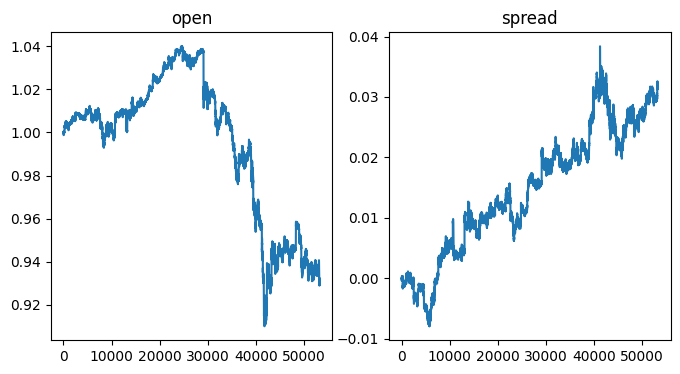

In [50]:
#Visualizing the results of using the bonds predictors
fig,axs = plt.subplots(1,2,sharex=True,sharey=False,figsize=(8,4))
columns = ["open","spread"]

for i,ax in enumerate(axs.flat):
    ax.plot(data_visualization.loc[:,columns[i]])
    ax.set_title(columns[i])

In [50]:
#Label the data
merged_data["target"] = merged_data["close"].shift(-look_ahead)

In [48]:
#Define the predictors and target
target = "target"
ohlc_predictors = ['open', 'high', 'low', 'close','tick_volume']
bonds_predictors = ['open usa','high usa','low usa','close usa','tick_volume usa','open japan','high japan', 'low japan', 'close japan','tick_volume japan']
predictors = ['open usa','high usa','low usa','close usa','tick_volume usa','open japan','high japan', 'low japan', 'close japan','tick_volume japan','open', 'high', 'low', 'close','tick_volume']
all_data = predictors + [target]

In [51]:
merged_data = merged_data.loc[:,all_data]

In [52]:
#Create new columns for our target
merged_data["binary target"] = np.nan
merged_data.loc[merged_data["close"] > merged_data["target"],"binary target"] = 0
merged_data.loc[merged_data["close"] < merged_data["target"],"binary target"] = 1
merged_data.dropna(inplace=True)
merged_data.reset_index(inplace=True)
merged_data

index  open usa  high usa   low usa  close usa  tick_volume usa  \
0          0  1.000000  1.000000  1.000000   1.000000         1.000000   
1          1  1.000000  0.999854  0.999863   0.999863         0.666667   
2          2  0.999863  0.999854  0.999863   0.999863         2.000000   
3          3  0.999863  0.999717  0.999863   0.999863         0.333333   
4          4  0.999863  0.999717  0.999863   0.999863         0.333333   
...      ...       ...       ...       ...        ...              ...   
52895  53191  1.036528  1.036377  1.036528   1.036528         0.333333   
52896  53192  1.036528  1.036377  1.036528   1.036528         0.333333   
52897  53193  1.036528  1.036377  1.036528   1.036528         0.333333   
52898  53194  1.036528  1.036377  1.036528   1.036528         0.333333   
52899  53195  1.036528  1.036377  1.036391   1.036528         1.000000   

       open japan  high japan  low japan  close japan  tick_volume japan  \
0        1.000000    1.000000   1.000000     1.000000                1.0   
1        1.000000    1.000000   0.999930     0.999930                4.0   
2        0.999930    0.999930   0.999930     0.999930                1.0   
3        0.999930    0.999930   0.999930     0.999930                1.0   
4        0.999930    0.999930   0.999861     0.999861                2.0   
...           ...         ...        ...          ...                ...   
52895    1.006467    1.006537   1.006467     1.006467                3.0   
52896    1.006467    1.006467   1.006467     1.006467                1.0   
52897    1.006467    1.006537   1.006467     1.006537                2.0   
52898    1.006537    1.006537   1.006398     1.006398                3.0   
52899    1.006398    1.006398   1.006398     1.006398                1.0   

           open      high       low     close  tick_volume    target  \
0      1.000000  1.000000  1.000000  1.000000     1.000000  1.001187   
1      0.999686  0.999647  1.000051  1.000019     0.714286  1.001354   
2      0.999654  0.999840  1.000148  1.000096     0.739130  1.001341   
3      0.999769  1.000071  1.000302  1.000475     0.670807  1.001354   
4      1.000141  1.000250  1.000674  1.000629     0.583851  1.001450   
...         ...       ...       ...       ...          ...       ...   
52895  0.927729  0.927735  0.928210  0.928097     0.416149  0.928584   
52896  0.927793  0.927838  0.928274  0.928097     0.552795  0.928520   
52897  0.927793  0.927895  0.928287  0.928251     0.378882  0.928398   
52898  0.927947  0.927992  0.928351  0.928167     0.403727  0.928373   
52899  0.927864  0.928043  0.928281  0.928424     0.447205  0.928533   

       binary target  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  
...              ...  
52895            1.0  
52896            1.0  
52897            1.0  
52898            1.0  
52899            1.0  

[52900 rows x 18 columns]

<Axes: >

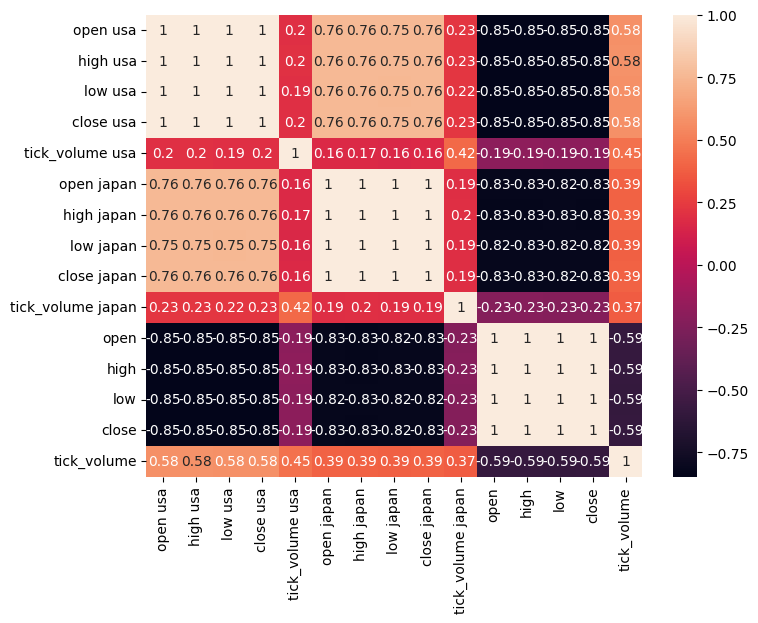

In [53]:
#Analyze correlation levels
plt.subplots(figsize=(8,6))
sns.heatmap(merged_data.loc[:,predictors].corr(),annot=True)

<Axes: xlabel='open usa', ylabel='open'>

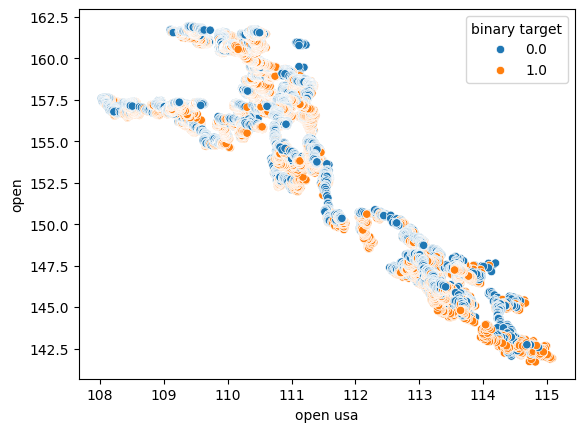

In [104]:
#Let's create more visualizations 
sns.scatterplot(x="open usa",y="open",data=merged_data,hue="binary target")

<Axes: xlabel='open japan', ylabel='open'>

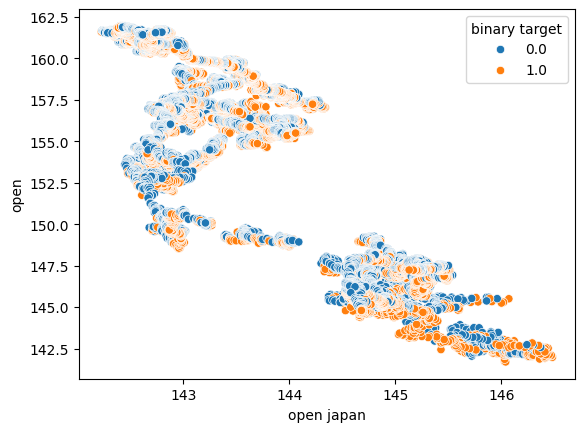

In [105]:
#Let's create more visualizations 
sns.scatterplot(x="open japan",y="open",data=merged_data,hue="binary target")

<Axes: xlabel='open japan', ylabel='open usa'>

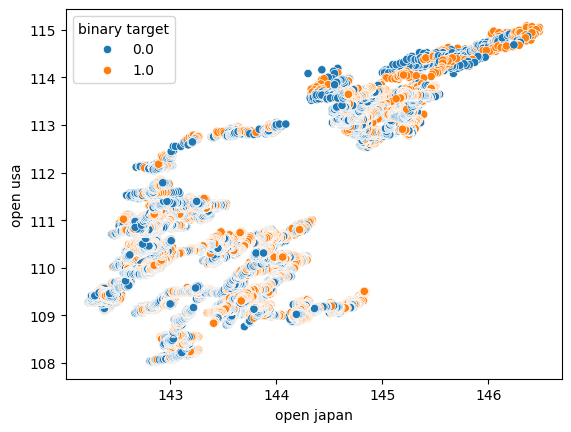

In [106]:
#Let's create more visualizations 
sns.scatterplot(x="open japan",y="open usa",data=merged_data,hue="binary target")

<Axes: xlabel='tick_volume usa', ylabel='close'>

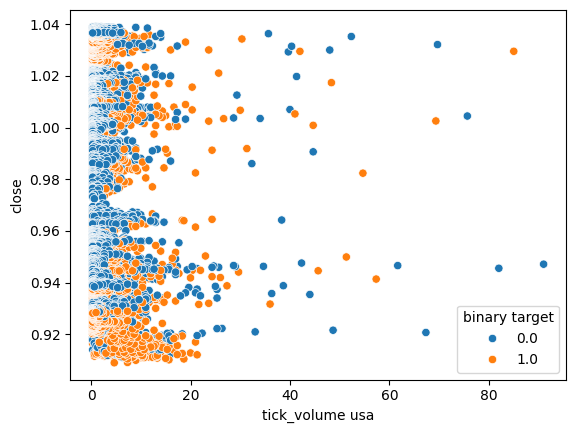

In [54]:
#Let's create more visualizations 
sns.scatterplot(x="tick_volume usa",y="close",data=merged_data,hue="binary target")

In [12]:
#Scale the data
scaled_data = pd.DataFrame(RobustScaler().fit_transform(merged_data.loc[:,predictors]),columns=predictors)

In [13]:
#Partition the data
train_X , test_X, train_y, test_y = train_test_split(scaled_data,merged_data.loc[:,target],shuffle=False,test_size=0.5)

In [15]:
#Model selection
from sklearn.linear_model import LinearRegression , Lasso , SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor , RandomForestRegressor , BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit

#Define the columns
columns = [
    "Linear Model",
    "Lasso",
    "SGD",
    "Linear SV",
    "Gradient Boost",
    "Random Forest",
    "Bagging",
    "K Neighbors",
    "Neural Network"
]

#Define the models
models = [
    LinearRegression(),
    Lasso(),
    SGDRegressor(),
    LinearSVR(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    BaggingRegressor(),
    KNeighborsRegressor(),
    MLPRegressor(hidden_layer_sizes=(100,40,20,10),shuffle=False)
]

#Create 2 dataframes to store our error on the training and test sets respectively
ohlc_training_loss = pd.DataFrame(index=np.arange(0,5),columns=columns)
ohlc_validation_loss = pd.DataFrame(index=np.arange(0,5),columns=columns)
bonds_training_loss = pd.DataFrame(index=np.arange(0,5),columns=columns)
bonds_validation_loss = pd.DataFrame(index=np.arange(0,5),columns=columns)
all_training_loss = pd.DataFrame(index=np.arange(0,5),columns=columns)
all_validation_loss = pd.DataFrame(index=np.arange(0,5),columns=columns)
#Create the time-series split object
tscv = TimeSeriesSplit(n_splits=5,gap=look_ahead)

In [214]:
#Now perform cross validation
for j in np.arange(0,len(models)):
    model = models[j]
    for i,(train,test) in enumerate(tscv.split(train_X)):
        model.fit(train_X.loc[train[0]:train[-1],predictors],train_y.loc[train[0]:train[-1]])
        all_training_loss.iloc[i,j] = mean_squared_error(train_y.loc[train[0]:train[-1]],model.predict(train_X.loc[train[0]:train[-1],predictors]))
        all_validation_loss.iloc[i,j] = mean_squared_error(train_y.loc[test[0]:test[-1]],model.predict(train_X.loc[test[0]:test[-1],predictors]))

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [197]:
#Our results using the OHLC data
ohlc_validation_loss

Linear Model      Lasso       SGD Linear SV Gradient Boost Random Forest  \
0     0.014376   0.552437  0.257721  0.014305       0.081594      0.085109   
1     0.022648   0.420159  0.028992  0.022872       0.023947      0.025636   
2     0.011391   1.347761  0.025657  0.011156       0.166265       0.18482   
3      0.00724   9.313717  0.012527  0.006156       1.813508      1.735097   
4      0.01002  14.070383  0.010127  0.010178       0.157801      0.142803   

    Bagging K Neighbors Neural Network  
0  0.079231    0.109452       2.056317  
1  0.026638    0.029344       0.167444  
2  0.186179    0.182792       0.075501  
3  1.740352    1.869318       1.989941  
4  0.142231    0.172946       0.330106

In [203]:
#Our results using the bonds data
bonds_validation_loss

Linear Model      Lasso       SGD Linear SV Gradient Boost Random Forest  \
0     0.496858   0.552437  2.432504  0.615103       0.291882      0.312947   
1     0.585756   0.420159  1.280156  0.862832       0.518306      0.526689   
2     4.083401   1.347761   4.15925  4.117462       2.604119      3.550374   
3     5.716875   9.313717  5.704324  6.584329        9.66595      9.590219   
4      2.14507  14.070383  2.118775  1.071814       8.445743      9.105799   

    Bagging K Neighbors Neural Network  
0  0.314594    0.330059      66.534706  
1  0.526043    0.356457      34.115323  
2  3.589469    3.548742       4.364108  
3  9.412782    8.957158      121.88144  
4  8.522173     4.39266      11.754601

In [215]:
#Our results using all the data we have
all_validation_loss

Linear Model      Lasso       SGD Linear SV Gradient Boost Random Forest  \
0     0.014617   0.552437  7.271071   0.07472       0.101075      0.103181   
1     0.023204   0.420159  0.722624  0.028933       0.028219       0.02681   
2      0.01541   1.347761  0.803308  0.014787       0.565687      0.489319   
3     0.006879   9.313717   0.00784  0.006172       2.042659      1.899419   
4     0.010056  14.070383  0.010445  0.010215       0.188626       0.16981   

    Bagging K Neighbors Neural Network  
0  0.103358    0.279899     214.734722  
1  0.028067    0.268299      13.305427  
2  0.340087    2.549086      29.613773  
3  1.907116    5.548212      65.879364  
4  0.188177    0.838891       3.967736

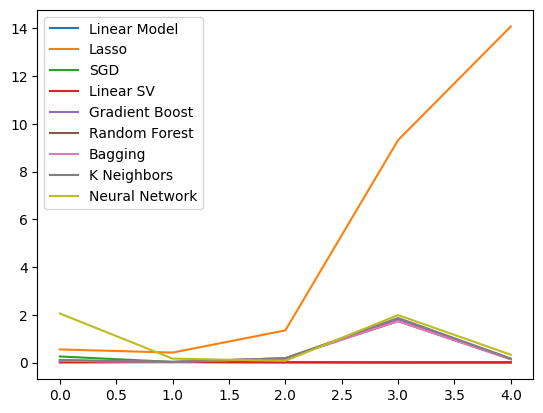

In [198]:
#Visualizing the results of using the OHLC predictors
plt.plot(ohlc_validation_loss)
plt.legend(columns)

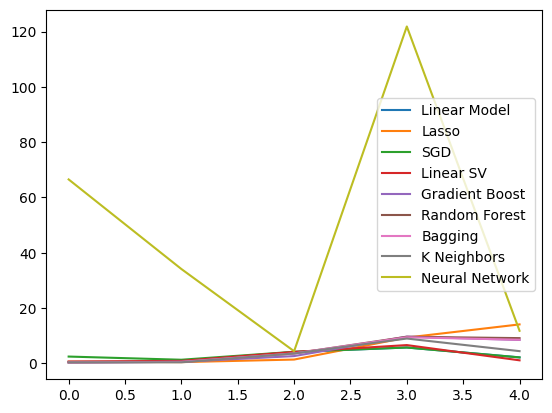

In [204]:
#Visualizing the results of using the bonds predictors
plt.plot(bonds_validation_loss)
plt.legend(columns)

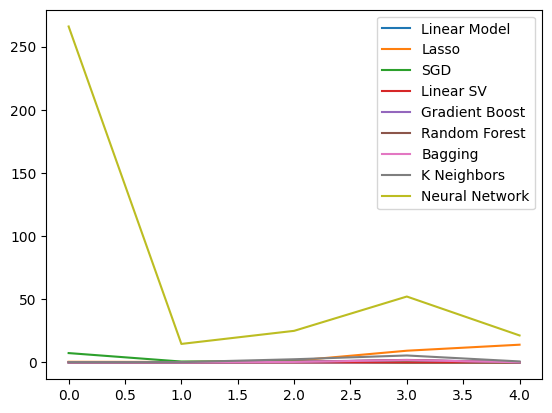

In [208]:
#Visualizing the results of using the bonds predictors
plt.plot(all_validation_loss)
plt.legend(columns)

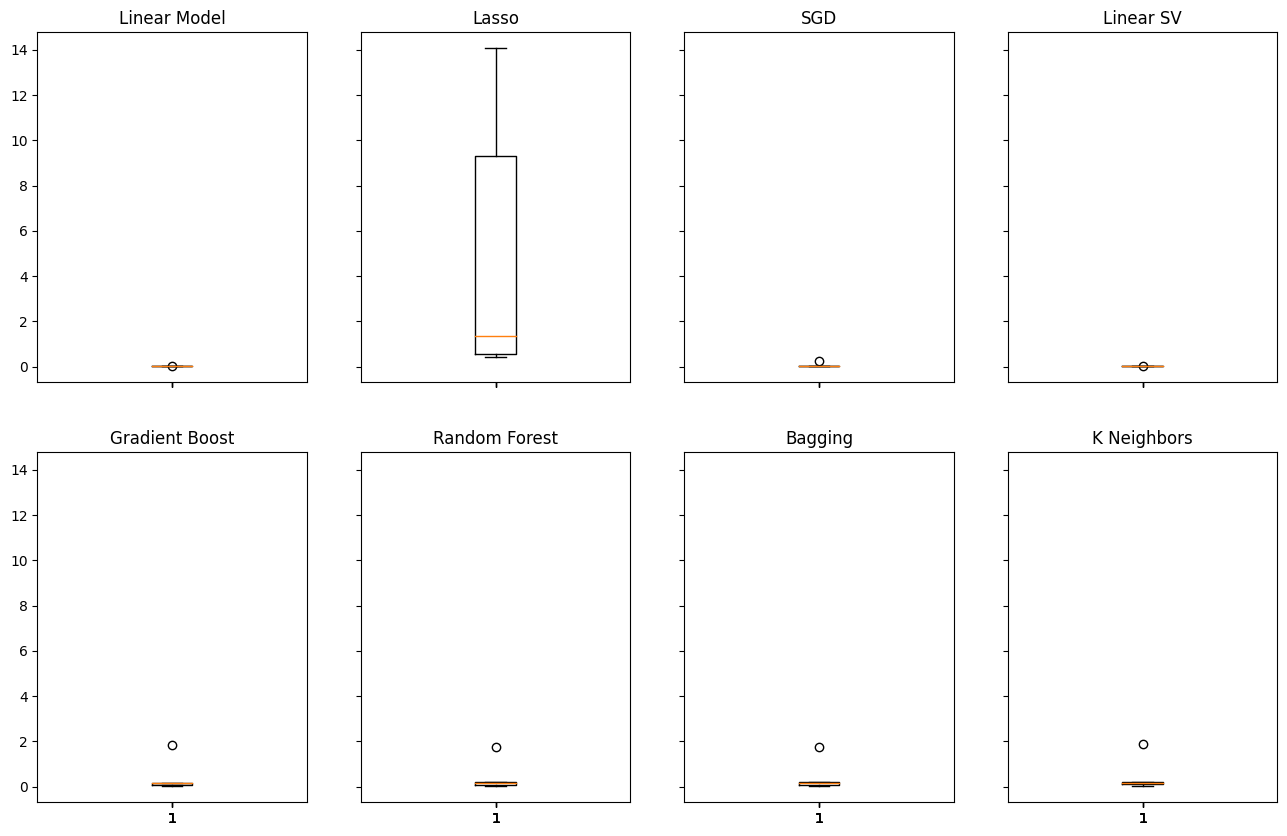

In [199]:
#Visualizing the results of using the OHLC predictors
fig,axs = plt.subplots(2,4,sharex=True,sharey=True,figsize=(16,10))

for i,ax in enumerate(axs.flat):
    ax.boxplot(ohlc_validation_loss.iloc[:,i])
    ax.set_title(columns[i])

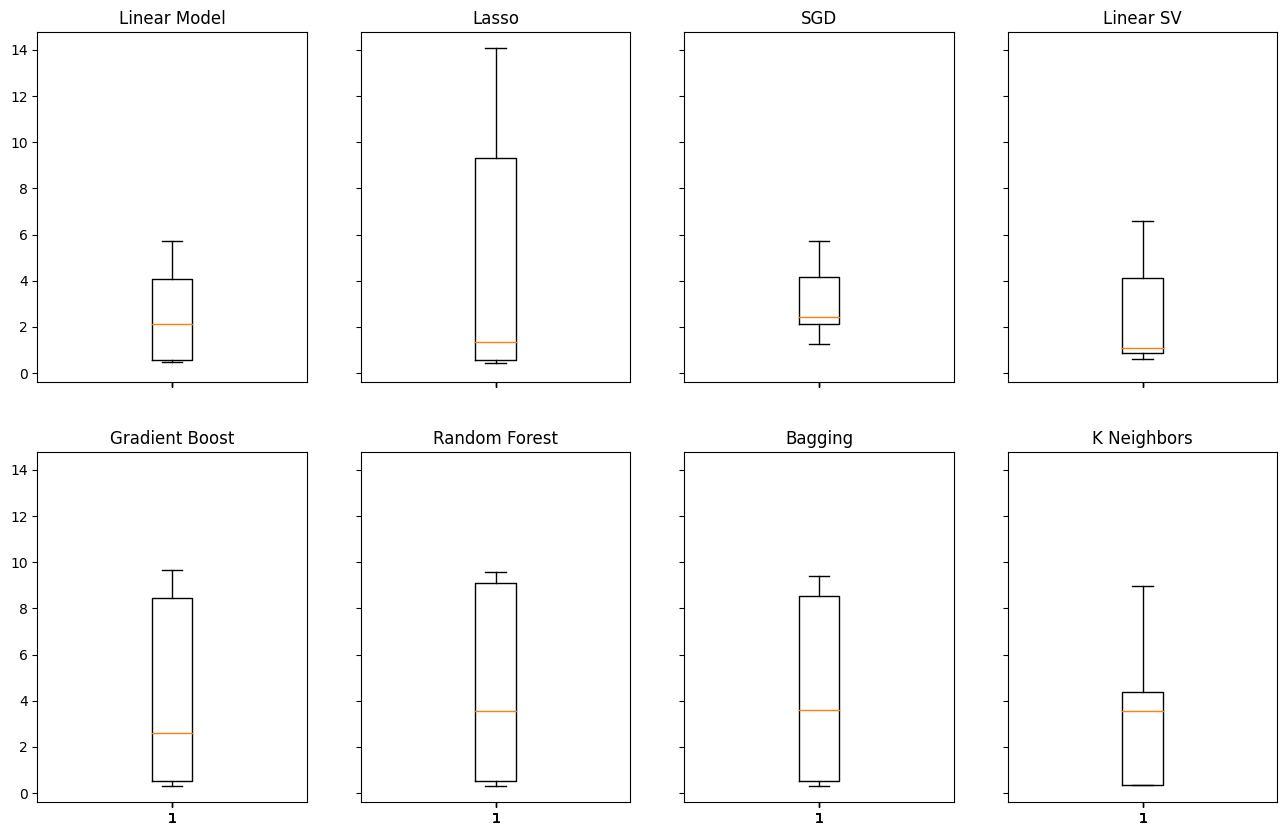

In [205]:
#Visualizing the results of using the bonds predictors
fig,axs = plt.subplots(2,4,sharex=True,sharey=True,figsize=(16,10))

for i,ax in enumerate(axs.flat):
    ax.boxplot(bonds_validation_loss.iloc[:,i])
    ax.set_title(columns[i])

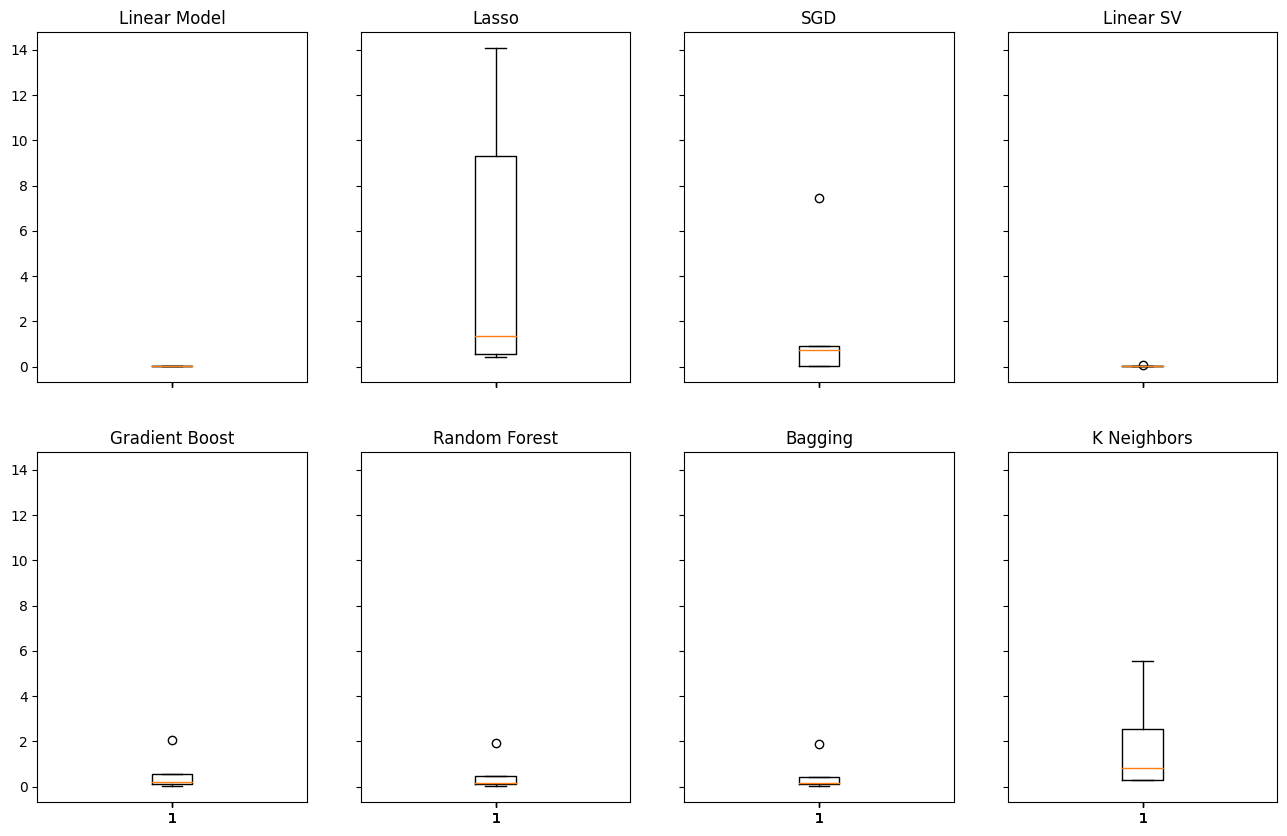

In [209]:
#Visualizing the results of using the bonds predictors
fig,axs = plt.subplots(2,4,sharex=True,sharey=True,figsize=(16,10))

for i,ax in enumerate(axs.flat):
    ax.boxplot(all_validation_loss.iloc[:,i])
    ax.set_title(columns[i])

In [210]:
#Feature selection
import shap

In [220]:
#The SVR performed quite well, let's inspect it further
model = LinearSVR()
model.fit(train_X,train_y)

Liblinear failed to converge, increase the number of iterations.


LinearSVR()

In [221]:
#Calculate SHAP Values
explainer = shap.Explainer(model.predict,test_X)
shap_values = explainer(test_X)

PermutationExplainer explainer: 26472it [10:07, 42.85it/s]                                                                                                                   


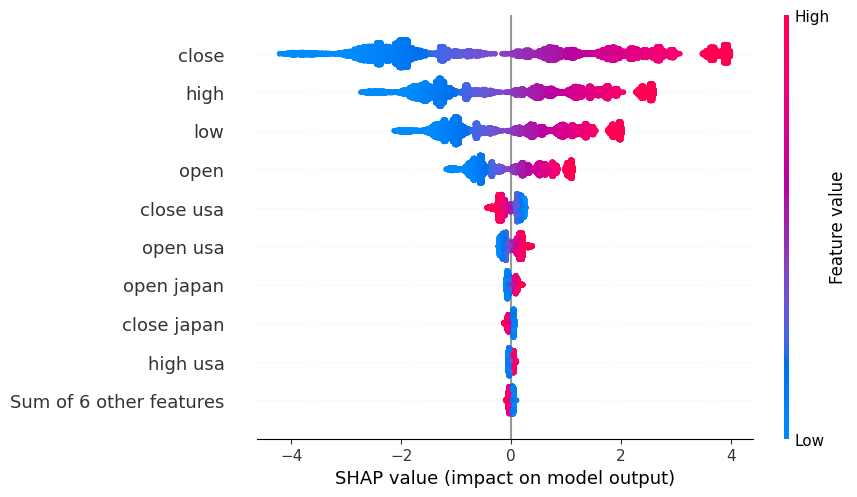

In [222]:
shap.plots.beeswarm(shap_values)

In [231]:
#Let's also perform backward selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [226]:
#Reinitialize the model
model = LinearSVR()

In [227]:
#Prepare the feature selector
sfs = SFS(model,
         k_features=(1,train_X.shape[1]),
         forward=False,
          n_jobs = -1,
          scoring="neg_mean_squared_error",
          cv=5)

In [228]:
#Fit the feature selector
sfs_results = sfs.fit(train_X,train_y)

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


In [229]:
#The best features we identified
sfs_results.k_feature_names_

('open usa',
 'high usa',
 'tick_volume usa',
 'open japan',
 'low japan',
 'close',
 'tick_volume')

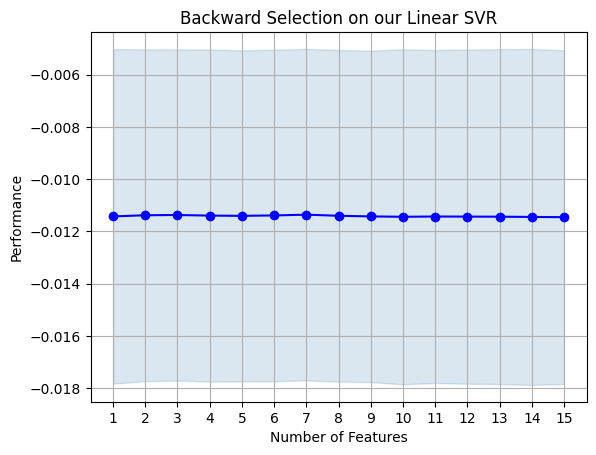

In [232]:
#Prepare the plot
fig1 = plot_sfs(sfs_results.get_metric_dict(),kind="std_dev")
plt.title("Backward Selection on our Linear SVR")
plt.grid()

In [44]:
#Parameter tuning 
from sklearn.model_selection import RandomizedSearchCV

In [45]:
#Reinitialize the model
model = LinearSVR()

In [46]:
tuner = RandomizedSearchCV(model,
                          {
                              "epsilon":[0,0.001,0.01,0.1,25,50,100],
                              "tol": [0.1,0.01,0.001,0.0001,0.00001],
                              "C" : [1,5,10,50,100,1000,10000,100000],
                              "loss":["epsilon_insensitive", "squared_epsilon_insensitive"],
                              "fit_intercept": [False,True]
                          },
                           n_jobs=-1,
                           n_iter=100,
                           scoring="neg_mean_squared_error"
                          )

In [47]:
tuner_results = tuner.fit(train_X,train_y)

C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [249]:
tuner_results.best_params_

{'tol': 0.0001,
 'loss': 'epsilon_insensitive',
 'fit_intercept': True,
 'epsilon': 0,
 'C': 1}

In [18]:
#Testing for overfitting
baseline_model = LinearRegression()
default_model =  LinearSVR()
customized_model = LinearSVR(tol=0.0001,loss='epsilon_insensitive',fit_intercept=True,epsilon=0,C=1)

In [20]:
#Fit the models
baseline_model.fit(train_X,train_y)
default_model.fit(train_X,train_y)
customized_model.fit(train_X,train_y)

C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(C=1, epsilon=0)

In [27]:
#Create a list of models
models = [
    baseline_model,
    default_model,
    customized_model
]

columns = [
    "Linear Regression",
    "Default Linear SVR",
    "Customized Linear SVR"
]

In [24]:
#Let's asses our new accuracy levels
test_y = test_y.reset_index()
test_X.reset_index(inplace=True)

In [28]:
#Create our time-series test object
tscv = TimeSeriesSplit(n_splits=5,gap=look_ahead)
overfitting_error = pd.DataFrame(columns=columns,index=np.arange(0,5))

In [32]:
for j in np.arange(0,len(columns)):
    model = models[j]
    for i , (train,test) in enumerate(tscv.split(test_X)):
        model.fit(test_X.loc[train[0]:train[-1],predictors],test_y.loc[train[0]:train[-1],"target"])
        overfitting_error.iloc[i,j] = mean_squared_error(test_y.loc[test[0]:test[-1],"target"],model.predict(test_X.loc[test[0]:test[-1],predictors]))

C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

In [33]:
overfitting_error

Linear Regression Default Linear SVR Customized Linear SVR
0          0.074529           0.033304              0.033446
1          0.061614           0.071299              0.070584
2          0.151724           0.145606              0.145884
3          0.033802           0.038605              0.032585
4          0.033426           0.033792               0.03421

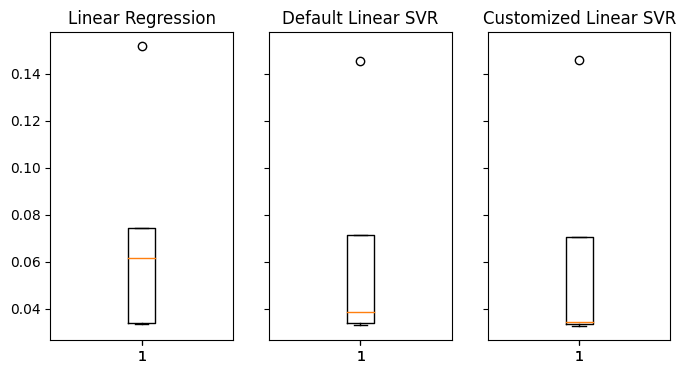

In [40]:
#Visualizing the results of using the bonds predictors
fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8,4))

for i,ax in enumerate(axs.flat):
    ax.boxplot(overfitting_error.iloc[:,i])
    ax.set_title(columns[i])

In [52]:
#Create scaling factors
scaling_factors = pd.DataFrame(index=("mean","standard deviation"),columns=predictors)

#Write our the values
for i in np.arange(0,scaling_factors.shape[1]):
    scaling_factors.iloc[0,i] = merged_data.loc[:,predictors[i]].mean()
    scaling_factors.iloc[1,i] = merged_data.loc[:,predictors[i]].std()
    merged_data.loc[:,predictors[i]] = ((merged_data.loc[:,predictors[i]] - scaling_factors.iloc[0,i]) / scaling_factors.iloc[1,i])

scaling_factors

open usa  high usa     low usa   close usa  \
mean                110.950048  110.9554  110.944804  110.950106   
standard deviation     1.56489  1.566398    1.563488    1.564929   

                   tick_volume usa  open japan  high japan  low japan  \
mean                      3.797439  143.599054  143.603155  143.59504   
standard deviation        6.650847     0.86903    0.870478   0.867652   

                   close japan tick_volume japan        open        high  \
mean                143.599041          2.454686  154.894125  154.912556   
standard deviation     0.86901          2.306523    5.218026    5.209585   

                          low       close tick_volume  
mean                154.87534  154.893926  105.847796  
standard deviation   5.226655    5.218159   68.017441

In [68]:
#Save the scaling factors
scaling_factors.to_csv("C:\\Users\\Westwood\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075\\MQL5\\Files\\usdjpy scaling factors.csv")

In [53]:
merged_data

index                time  open usa  high usa   low usa  close usa  \
0          0 2024-05-20 09:15:00 -0.973262 -0.975742 -0.970781  -0.973275   
1          1 2024-05-20 09:17:00 -0.973262 -0.975742 -0.970781  -0.973275   
2          2 2024-05-20 09:18:00 -0.973262 -0.975742 -0.970781  -0.973275   
3          3 2024-05-20 09:19:00 -0.973262 -0.975742 -0.975898  -0.978387   
4          4 2024-05-20 09:21:00 -0.982847 -0.985318 -0.980375  -0.982860   
...      ...                 ...       ...       ...       ...        ...   
52937  53236 2024-08-23 18:33:00  1.722774  1.717699  1.717439   1.722694   
52938  53237 2024-08-23 18:34:00  1.722774  1.727913  1.717439   1.712470   
52939  53238 2024-08-23 18:35:00  1.712549  1.717699  1.717439   1.722694   
52940  53239 2024-08-23 18:36:00  1.722774  1.717699  1.717439   1.722694   
52941  53240 2024-08-23 18:37:00  1.722774  1.717699  1.717439   1.722694   

       tick_volume usa  spread usa  real_volume usa  open japan  ...  \
0            -0.420614          36                0    0.116159  ...   
1            -0.420614          36                0    0.116159  ...   
2            -0.420614          36                0    0.116159  ...   
3             0.030456          36                0    0.116159  ...   
4            -0.420614          36                0    0.116159  ...   
...                ...         ...              ...         ...  ...   
52937         0.180813          36                0    1.255360  ...   
52938         0.331170          36                0    1.243853  ...   
52939         0.030456          36                0    1.243853  ...   
52940         0.180813          36                0    1.243853  ...   
52941         0.180813          36                0    1.243853  ...   

       real_volume japan      open      high       low     close  tick_volume  \
0                      0  0.156740  0.156336  0.160076  0.159266    -0.850485   
1                      0  0.159615  0.161134  0.162180  0.163482    -0.571145   
2                      0  0.163448  0.163246  0.166389  0.163482    -0.909293   
3                      0  0.163448  0.164206  0.166581  0.165590    -0.835783   
4                      0  0.163831  0.167661  0.167155  0.170189    -0.497634   
...                  ...       ...       ...       ...       ...          ...   
52937                  0 -1.931981 -1.935578 -1.927876 -1.932085     1.193109   
52938                  0 -1.931981 -1.931163 -1.927302 -1.924994     0.722641   
52939                  0 -1.925273 -1.928091 -1.927684 -1.934001     0.913769   
52940                  0 -1.934089 -1.936345 -1.927684 -1.934385     0.002238   
52941                  0 -1.934472 -1.930779 -1.927684 -1.924994     1.457747   

       spread  real_volume   target  binary target  
0           0            0  155.690            0.0  
1           0            0  155.702            0.0  
2           0            0  155.699            0.0  
3           0            0  155.698            0.0  
4           0            0  155.670            0.0  
...       ...          ...      ...            ...  
52937       0            0  144.951            1.0  
52938       0            0  144.937            1.0  
52939       0            0  144.932            1.0  
52940       0            0  144.926            1.0  
52941       0            0  144.868            1.0  

[52942 rows x 25 columns]

In [54]:
#Fit the model on all the data we have
customized_model.fit(merged_data.loc[:,predictors],merged_data.loc[:,"target"])

C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(C=1, epsilon=0)

In [59]:
#Let's import the libraries we need
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
import netron
import onnx

In [60]:
#Define the initial input types
initial_types = [('float_input',FloatTensorType([1,len(predictors)]))]

In [64]:
#Create an ONNX representation of the model
onnx_model = convert_sklearn(customized_model,initial_types=initial_types,target_opset=12)

In [65]:
#Save the ONNX model
onnx_name = "USDJPY M1 FLOAT.onnx"
onnx.save(onnx_model,onnx_name)

In [66]:
#Visualize the model
netron.start(onnx_name)

Serving 'USDJPY M1 FLOAT.onnx' at http://localhost:8080


('localhost', 8080)